<center style="font-weight:bold;font-size:20px">wbenbihi/hourglasstensorlfow: Stacked Hourglass Network for Human Pose Estimation</center>

<center style="font-weight:bold;font-size:20px">Model Illustration</center>

# Setup

## Imports

In [1]:
import os
import sys
sys.path.append(os.path.join('..'))

In [2]:
import math
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import tensorflow as tf
from skimage.io import imread
from skimage.transform import resize
from utils import ROOT_PATH, load_configuration
sns.set()

## Global Variables

In [3]:
ROOT_FOLDER = ROOT_PATH
DATA_FOLDER = 'data'
IMAGE_FOLDER = 'images'
LABELS_FILE = "MPII_DATASET_LABELS.csv"

In [3]:
CFG = load_configuration(os.path.join(ROOT_PATH, 'config', 'hpeDefault.yml'))

# Function definition

# Main Code

## Model Coherence Check

In [4]:
print("Model Input Size:", CFG.data.input_size)
print("Model Output Size:", CFG.data.output_size)

Model Input Size: 256
Model Output Size: 64


The first element to check is the integer coefficient between input and output size to determine the number of downsizing.

In [5]:
assert (CFG.data.input_size / CFG.data.output_size).is_integer(), 'InputSize is not divisible by OutputSize'
PREPROCESS_DOWNSIZING = int(CFG.data.output_size / CFG.data.output_size) -1

We then check if our input image mode is genuine to define the channel numbers

In [6]:
assert CFG.data.mode in ["RGB", "BGR", "HSV", "HSL", "GRAY"], 'The input image mode is not recognized'
if CFG.data.mode in ["RGB", "BGR", "HSV", "HSL"]:
    CHANNELS = 3
elif CFG.data.mode in ["GRAYSCALE"]:
    CHANNELS = 1

## Layer Definition

To illustrate our model creation we'll use `tf.keras` API.

### Layer definition

In [7]:
def conv_2d(input_tensor, filters, kernel_size, strides=1, activation=None, kernel_initializer='glorot_uniform',padding="same", prefix=""):
    x = tf.keras.layers.Conv2D(
        filters=filters,
        kernel_size=kernel_size,
        strides=strides,
        padding=padding,
        name=prefix+"conv_2d",
        activation=activation,
        kernel_initializer=kernel_initializer,
    )(input_tensor)
    return x

In [8]:
def batch_norm(input_tensor, momentum=0.9, epsilon=1e-5, trainable=True, prefix=""):
    x = tf.keras.layers.BatchNormalization(
        axis=-1,
        momentum=momentum,
        epsilon=epsilon,
        trainable=trainable,
        name=prefix+"batch_norm",
    )(input_tensor)
    return x

In [9]:
def conv_batch_norm_relu(input_tensor, filters, kernel_size, strides=1, activation=None, kernel_initializer='glorot_uniform',padding="same", prefix="", momentum=0.9, epsilon=1e-5, trainable=True):
    x = conv_2d(
        input_tensor=input_tensor,
        filters=filters,
        kernel_size=kernel_size,
        strides=strides,
        activation=activation,
        kernel_initializer=kernel_initializer,
        padding=padding,
        prefix=prefix+'conv_bn_relu_'
    )
    x = batch_norm(
        x, 
        momentum=0.9, 
        epsilon=1e-5, 
        trainable=True,
        prefix=prefix+'conv_bn_relu_'
    )
    x = tf.keras.layers.ReLU(name=prefix+"relu")(x)
    return x

In [10]:
def conv_block(input_tensor, numOut, prefix="", trainable=True):
    x = batch_norm(input_tensor, momentum=0.9, epsilon=1e-5, trainable=True, prefix=prefix+"conv_block_1_")
    x = tf.keras.layers.ReLU(name=prefix+"conv_block_1_relu")(x)
    x = conv_2d(x, filters=numOut//2, kernel_size=1, strides=1, padding="same", prefix=prefix+"conv_block_1_")
    
    x = batch_norm(x, momentum=0.9, epsilon=1e-5, trainable=True, prefix=prefix+"conv_block_2_")
    x = tf.keras.layers.ReLU(name=prefix+"conv_block_2_relu")(x)
    x = conv_2d(x, filters=numOut//2, kernel_size=3, strides=1, padding="same", prefix=prefix+"conv_block_2_")
    
    x = batch_norm(x, momentum=0.9, epsilon=1e-5, trainable=True, prefix=prefix+"conv_block_3_")
    x = tf.keras.layers.ReLU(name=prefix+"conv_block_3_relu")(x)
    x = conv_2d(x, filters=numOut, kernel_size=1, strides=1, padding="same", prefix=prefix+"conv_block_3_")
    return x

In [11]:
def skip_layer(input_tensor, numOut, prefix=""):
    if input_tensor.get_shape().as_list()[-1] == numOut:
        return input_tensor
    else:
        x = conv_2d(input_tensor, filters=numOut, kernel_size=1, strides=1, padding="same", prefix=prefix+"skip_layer_")
        return x

In [12]:
def residual(input_tensor, numOut, prefix="", trainable=True):
    convb = conv_block(input_tensor, numOut, prefix=prefix+"residual_", trainable=trainable)
    skipl = skip_layer(input_tensor, numOut, prefix=prefix+"residual_")
    return tf.add_n([convb, skipl], name=prefix+"residual_add")

### Layer Application

In [13]:
input_tensor = tf.keras.layers.Input(
    shape=(CFG.data.input_size, CFG.data.input_size, CHANNELS),
    name="demo_input_layer"
)

In [14]:
for i in range(PREPROCESS_DOWNSIZING):
    if i == 0:
        x = conv_batch_norm_relu(input_tensor, filters=64, kernel_size=6, strides=2, prefix=f"downsample_{i}_")
    elif i < PREPROCESS_DOWNSIZING - 1:
        x = residual(x, numOut=128, prefix=f"downsample_{i}_")
        x = tf.keras.layers.MaxPool2D(pool_size=(2, 2), padding="same", name=f"downsample_{i}_maxpool")(x)
    else:
        x = residual(x, numOut=256, prefix=f"downsample_{i}_")
autoencoder_input_tensor = x

In [15]:
input_tensor, autoencoder_input_tensor

(<tf.Tensor 'demo_input_layer:0' shape=(None, 256, 256, 3) dtype=float32>,
 <tf.Tensor 'downsample_2_residual_add:0' shape=(None, 64, 64, 256) dtype=float32>)

Our downsampling to the outputSize dimension is now complete. We can visualize the graph for the downsampling step.

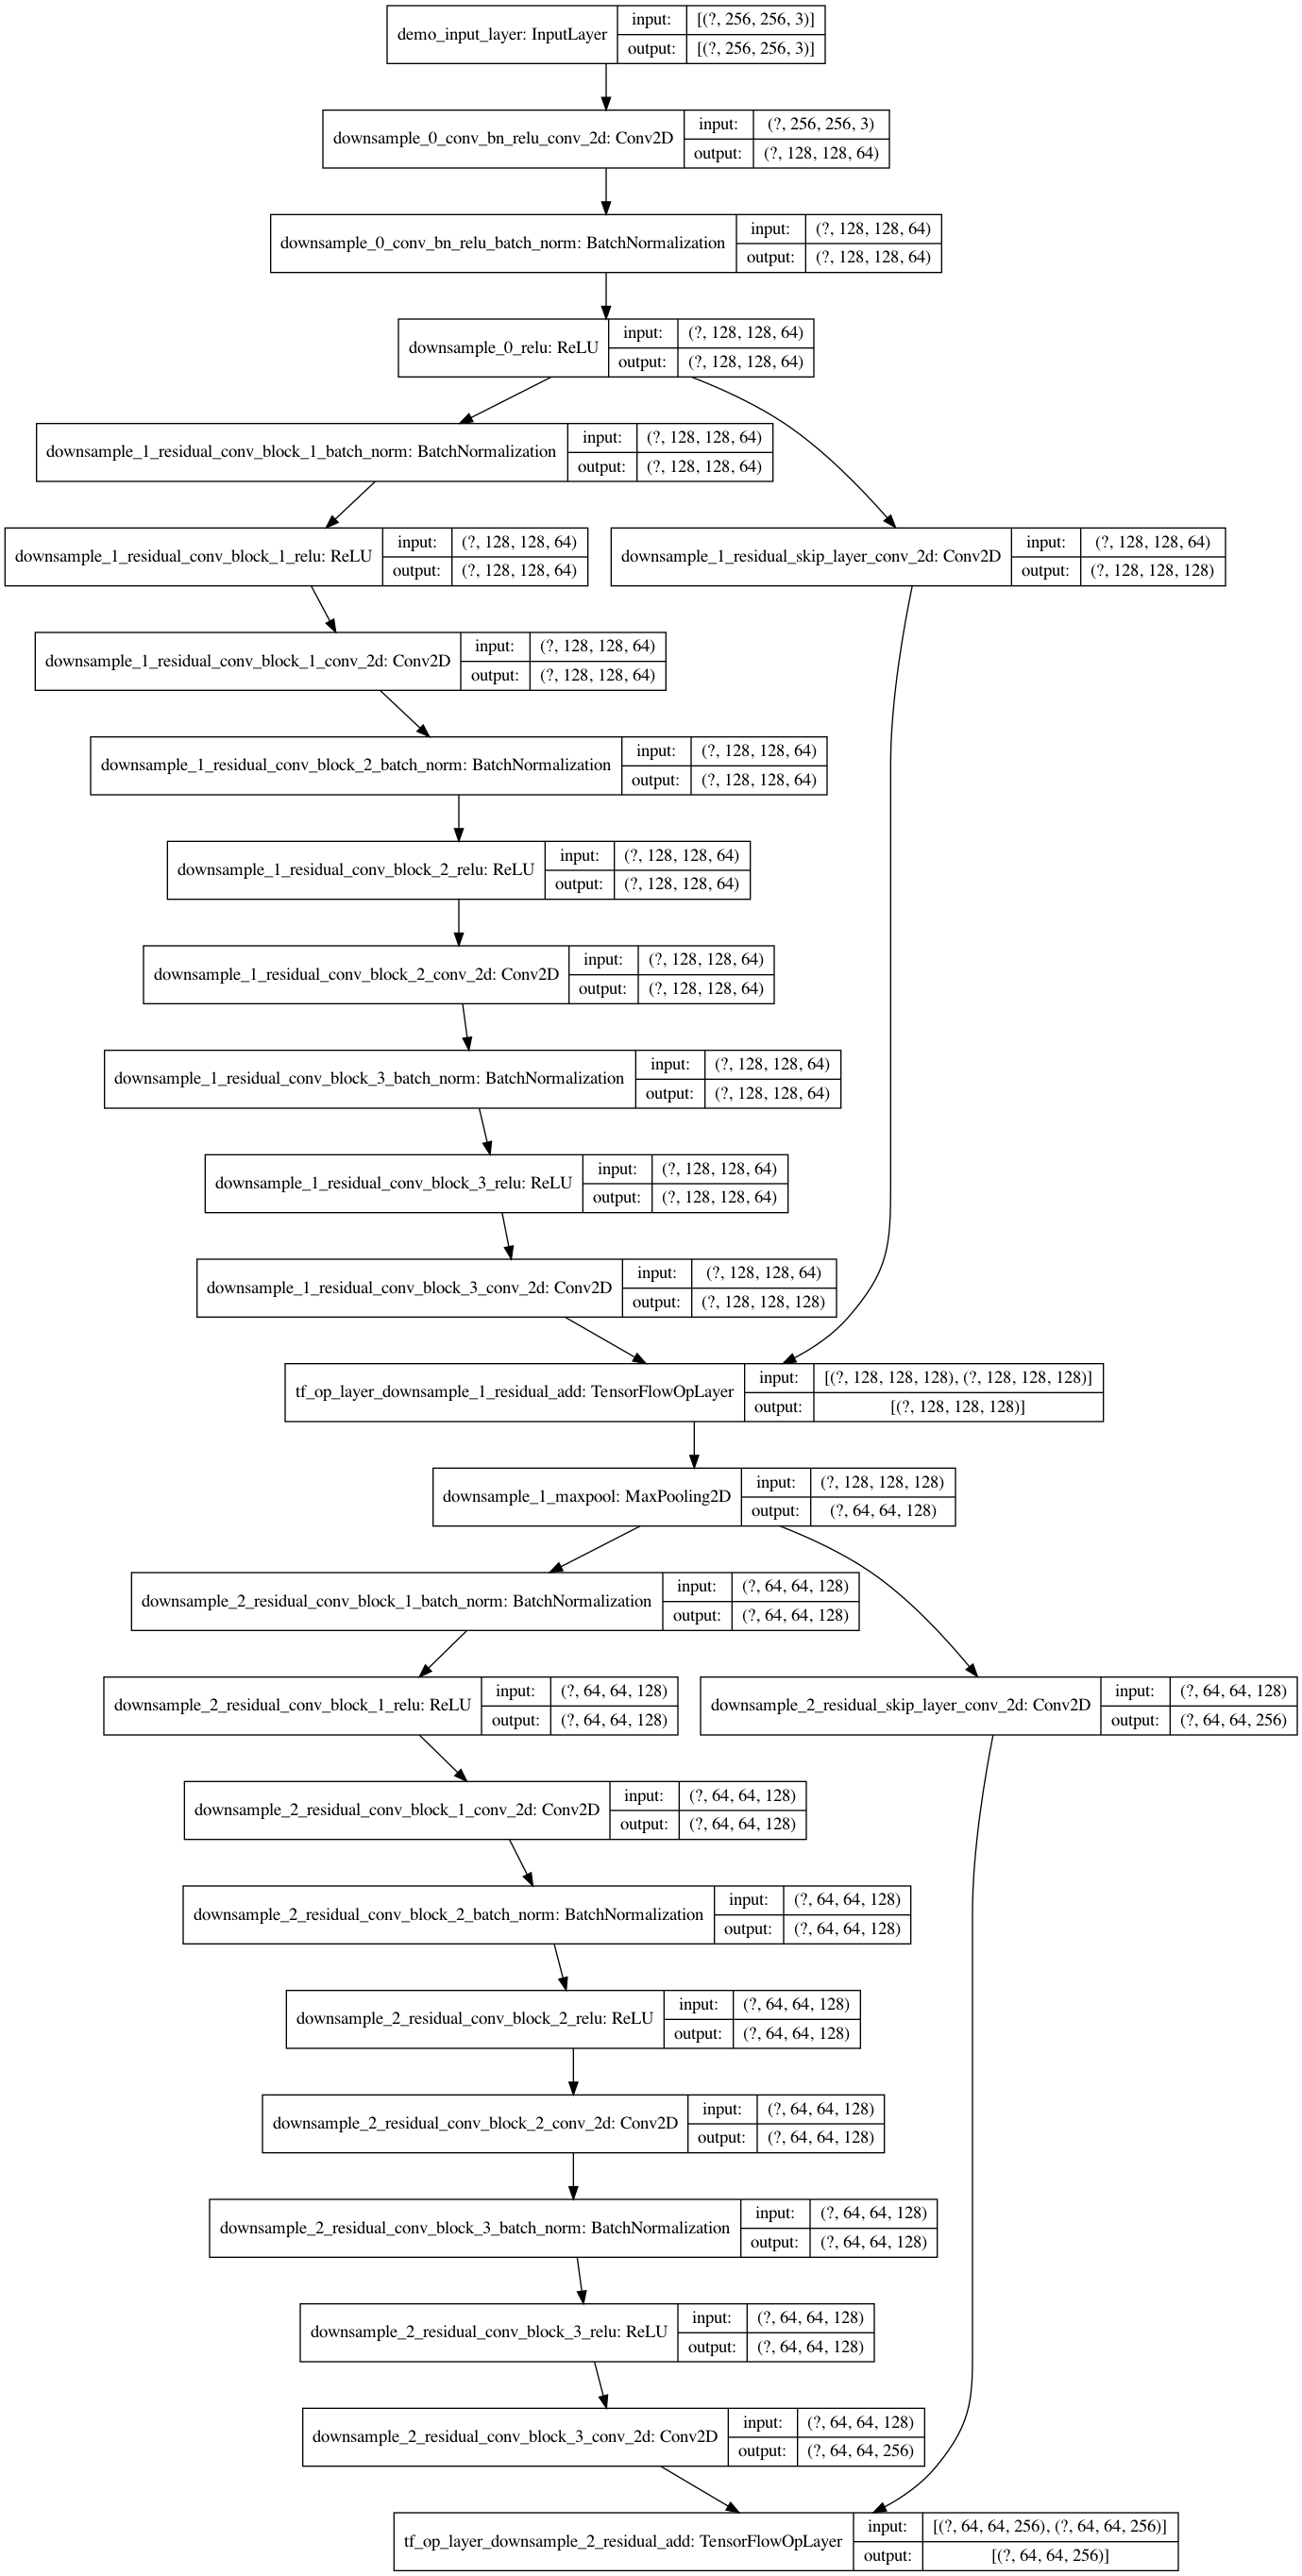

In [16]:
# We use the built-in keras method to visualize the graph.
# To replicate this cell you might need to install graphviz
# brew install graphviz
fake_model = tf.keras.Model(
    inputs = input_tensor,
    outputs=autoencoder_input_tensor,
)
tf.keras.utils.plot_model(fake_model, show_shapes=True)

As we can see, many basic layers are replicated over the graph, leading to low readability. For the purpose of this notebook we'll continue to develop the architecture with the same methodology and we'll provide another implementation with high level blocks to facilitate the graph understanding.

In [17]:
def hourglass(input_tensor, downsampling_steps, numOut, prefix=""):
    up_1 = residual(input_tensor, numOut=numOut, prefix=prefix+"up_1_")
    low_ = tf.keras.layers.MaxPool2D(pool_size=(2, 2), padding="same", name=prefix+f"maxpool_{downsampling_steps}_")(input_tensor)
    low_1 = residual(low_, numOut=numOut, prefix=prefix+"low_1_")
    if downsampling_steps > 0:
        low_2 = hourglass(low_1, downsampling_steps=downsampling_steps-1, numOut=numOut, prefix=prefix+"low_2_")
    else:
        low_2 = residual(low_1, numOut=numOut, prefix=prefix+"low_2_")
    low_3 = residual(low_2, numOut=numOut, prefix=prefix+"low_3_")
    up_2 = tf.image.resize(low_3,size=tf.shape(low_3)[1:3]*2, method="nearest", name=prefix+'upsampling')
    return tf.add_n([up_2,up_1], name='out_hg')

In [18]:
out_hg = hourglass(autoencoder_input_tensor, 3, numOut=256, prefix="hg_")

To illustrate our previous point on readability, we plot the graph for a single Hourglass/Autoencoder and we display the `tf.keras.Model.summary()` to grasp the need for reading ease.

In [19]:
fake_model = tf.keras.Model(
    inputs = input_tensor,
    outputs= out_hg,
)
tf.keras.utils.plot_model(fake_model, show_shapes=True)

In [20]:
fake_model.summary()

Model: "functional_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
demo_input_layer (InputLayer)   [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
downsample_0_conv_bn_relu_conv_ (None, 128, 128, 64) 6976        demo_input_layer[0][0]           
__________________________________________________________________________________________________
downsample_0_conv_bn_relu_batch (None, 128, 128, 64) 256         downsample_0_conv_bn_relu_conv_2d
__________________________________________________________________________________________________
downsample_0_relu (ReLU)        (None, 128, 128, 64) 0           downsample_0_conv_bn_relu_batch_n
_______________________________________________________________________________________

So far we have a trainable model with a single Houglass network, we will not build the full model in this notebook as it is simply a stacking _(for loop)_.

One improvement we'll make versus the previous version of `wbenbihi/hourglasstensorlfow` is to package some redundant graph blocks as `tf.keras.Layer` child classes.

# Tensorflow Packaging

## Layers

We can redefine all the above layers by creating sub-classes of the `tf.keras.layers.Layer` object

In [7]:
class BatchNormReluConv(tf.keras.layers.Layer):
    
    def __init__(
        self,
        filters:int,
        kernel_size:int,
        strides:int=1,
        padding:str="same",
        activation:str=None,
        kernel_initializer:str="glorot_uniform",
        name:str="",
        momentum:float=0.9,
        trainable:bool=False,
        epsilon:float=1e-5
    ):
        super(BatchNormReluConv, self).__init__()
        # Define Layers
        self.conv = tf.keras.layers.Conv2D(
            filters=filters,
            kernel_size=kernel_size,
            strides=strides,
            padding=padding,
            name=f"Conv2D",
            activation=activation,
            kernel_initializer=kernel_initializer,
        )
        self.batch_norm = tf.keras.layers.BatchNormalization(
            axis=-1,
            momentum=momentum,
            epsilon=epsilon,
            trainable=trainable,
            name=f"BatchNorm",
        )
        self.relu = tf.keras.layers.ReLU(name=f"ReLU",)
    
    def call(self, inputs, training=False):
        x = self.batch_norm(inputs, training=training)
        x = self.relu(x)
        x = self.conv(x)
        return x

In [8]:
class ConvBatchNormRelu(tf.keras.layers.Layer):
    
    def __init__(
        self,
        filters:int,
        kernel_size:int,
        strides:int=1,
        padding:str="same",
        activation:str=None,
        kernel_initializer:str="glorot_uniform",
        name:str="",
        momentum:float=0.9,
        trainable:bool=False,
        epsilon:float=1e-5
    ):
        super(ConvBatchNormRelu, self).__init__(name=name)
        # Define Layers
        self.conv = tf.keras.layers.Conv2D(
            filters=filters,
            kernel_size=kernel_size,
            strides=strides,
            padding=padding,
            name=f"Conv2D",
            activation=activation,
            kernel_initializer=kernel_initializer,
        )
        self.batch_norm = tf.keras.layers.BatchNormalization(
            axis=-1,
            momentum=momentum,
            epsilon=epsilon,
            trainable=trainable,
            name=f"BatchNorm",
        )
        self.relu = tf.keras.layers.ReLU(name=f"ReLU",)
    
    def call(self, inputs, training=False):
        x = self.conv(inputs)
        x = self.batch_norm(x, training=training)
        x = self.relu(x)
        return x

In [9]:
class ConvBlock(tf.keras.layers.Layer):
    
    def __init__(self, output_filters, trainable=True, momentum=0.9, epsilon=1e-5, name=""):
        super(ConvBlock, self).__init__(name=name)
        self.bnrc1 = BatchNormReluConv(
            filters=output_filters//2,
            kernel_size=1,
            name=f"BNRC1",
            momentum=momentum,
            epsilon=epsilon
        )
        self.bnrc2 = BatchNormReluConv(
            filters=output_filters//2,
            kernel_size=3,
            name=f"BNRC2",
            momentum=momentum,
            epsilon=epsilon
        )
        self.bnrc3 = BatchNormReluConv(
            filters=output_filters,
            kernel_size=1,
            name=f"BNRC3",
            momentum=momentum,
            epsilon=epsilon
        )
    
    def call(self, inputs, training=False):
        x = self.bnrc1(inputs, training=training)
        x = self.bnrc2(x, training=training)
        x = self.bnrc3(x, training=training)
        return x

In [10]:
class SkipLayer(tf.keras.layers.Layer):
    
    def __init__(self, output_filters, name=""):
        super(SkipLayer, self).__init__(name=name)
        self.output_filters = output_filters
        self.layer_name = name
        self.conv = tf.keras.layers.Conv2D(
            filters=self.output_filters,
            kernel_size=1,
            strides=1,
            padding="same",
            name=f"Conv2D",
            activation=None,
            kernel_initializer='glorot_uniform',
        )
    
    def call(self, inputs, training=False):
        if inputs.get_shape().as_list()[-1] == self.output_filters:
            return inputs
        else:
            return self.conv(inputs)

In [11]:
class ResidualLayer(tf.keras.layers.Layer):
    
    def __init__(self, output_filters, trainable=True, momentum=0.9, epsilon=1e-5, name=""):
        super(ResidualLayer, self).__init__(name=name)
        self.layer_name = name
        self.conv_block = ConvBlock(
            output_filters=output_filters, 
            trainable=trainable, 
            momentum=momentum, 
            epsilon=epsilon, 
            name=f"ConvBlock"
        )
        self.skip = SkipLayer(
            output_filters=output_filters, 
            name=f"Skip"
        )
        self.add = tf.keras.layers.Add(name=f"Add")
    
    def call(self, inputs, training=False):
        return self.add([self.conv_block(inputs, training=training), self.skip(inputs, training=training)])

In [12]:
class DownSamplingLayer(tf.keras.layers.Layer):
    
    def __init__(self, input_size:int=256, output_size:int=64, kernel_size:int=7, output_filters=256, trainable=True, name=""):
        super(DownSamplingLayer, self).__init__(name=name)
        
        assert input_size >= output_size, "Input size must be higher than by Output size"
        assert input_size % output_size == 0, "Input size not divisible by Output size"
        assert math.log2(input_size // output_size).is_integer(), "Input size divided by Output size should be a power of 2"
        self.iterations = int(math.log2(input_size // output_size) + 1)
        self.layers = []
        for i in range(self.iterations):
            if i == 0:
                self.layers.append(
                    ConvBatchNormRelu(
                        filters=(output_filters//4 if self.iterations > 1 else output_filters),
                        kernel_size=kernel_size,
                        strides=(2 if self.iterations > 1 else 1),
                        name=f"CBNR",
                        trainable=trainable,
                    )
                )
            elif i == self.iterations - 1:
                self.layers.append(
                    ResidualLayer(
                        output_filters=output_filters,
                        name=f"Residual{i}",
                        trainable=trainable,
                    )
                )
            else:
                self.layers.append(
                    ResidualLayer(
                        output_filters=output_filters//2,
                        name=f"Residual{i}",
                        trainable=trainable,
                    )
                )
                self.layers.append(
                    tf.keras.layers.MaxPool2D(
                        pool_size=(2, 2), 
                        padding="same", 
                        name=f"MaxPool{i}"
                    )
                )

    def call(self, inputs, training=False):
        x = inputs
        for layer in self.layers:
            x = layer(x, training=training)
        return x

In [13]:
class HourglassLayer(tf.keras.layers.Layer):
    def __init__(
        self,
        downsamplings: int = 4,
        feature_filters: int = 256,
        output_filters: int = 16,
        name: str = "",
        trainable: bool = True,
    ):
        super(HourglassLayer, self).__init__(name=name)
        self.downsamplings = downsamplings
        self.layers = [{} for i in range(downsamplings)]
        self.hm_output = ConvBatchNormRelu(
            filters=output_filters,
            kernel_size=1,
            name="HeatmapOutput",
            trainable=trainable,
        )
        self._output = ConvBatchNormRelu(
            filters=feature_filters,
            kernel_size=1,
            name="TransitOutput",
            trainable=trainable,
        )
        for downsampling in range(downsamplings):
            self.layers[downsampling]["up_1"] = ResidualLayer(
                output_filters=feature_filters,
                trainable=trainable,
                name=f"Step{downsampling}_ResidualUp1",
            )
            self.layers[downsampling]["low_"] = tf.keras.layers.MaxPool2D(
                pool_size=(2, 2), padding="same", name=f"Step{downsampling}_MaxPool"
            )
            self.layers[downsampling]["low_1"] = ResidualLayer(
                output_filters=feature_filters,
                trainable=trainable,
                name=f"Step{downsampling}_ResidualLow1",
            )
            if downsampling == 0:
                self.layers[downsampling]["low_2"] = ResidualLayer(
                    output_filters=feature_filters,
                    trainable=trainable,
                    name=f"Step{downsampling}_ResidualLow2",
                )
            self.layers[downsampling]["low_3"] = ResidualLayer(
                output_filters=feature_filters,
                trainable=trainable,
                name=f"Step{downsampling}_ResidualLow3",
            )
            self.layers[downsampling]["up_2"] = tf.keras.layers.UpSampling2D(
                size=(2, 2),
                data_format=None,
                interpolation="nearest",
                name=f"Step{downsampling}_UpSampling2D",
            )
            self.layers[downsampling]["out"] = tf.keras.layers.Add(
                name=f"Step{downsampling}_Add"
            )

    def _recursive_call(self, input_tensor, downsampling_step, training=False):
        up_1 = self.layers[downsampling_step]["up_1"](input_tensor, training=training)
        low_ = self.layers[downsampling_step]["low_"](input_tensor, training=training)
        low_1 = self.layers[downsampling_step]["low_1"](low_, training=training)
        if downsampling_step == 0:
            low_2 = self.layers[downsampling_step]["low_2"](low_1, training=training)
        else:
            low_2 = self._recursive_call(
                low_1, downsampling_step=downsampling_step - 1, training=training
            )
        low_3 = self.layers[downsampling_step]["low_3"](low_2, training=training)
        up_2 = self.layers[downsampling_step]["up_2"](low_3, training=training)
        out = self.layers[downsampling_step]["out"]([up_1, up_2], training=training)
        return out

    def call(self, inputs, training=False):
        x = self._recursive_call(
            input_tensor=inputs,
            downsampling_step=self.downsamplings - 1,
            training=training,
        )
        intermediate = self.hm_output(x, training=training)
        add = tf.add_n([inputs, self._output(intermediate, training=training), x], name=f"{self.name}_OutputAdd")
        return add, intermediate

## Model

We generate an `HourglassNetwork` object as a child-class of `tf.keras.models.Model`

In [14]:
class HourglassNetwork(tf.keras.models.Model):
    
    def __init__(
        self, 
        input_size=256, 
        output_size=64,
        stages=4,
        downsampling_steps_per_stage=4,
        inner_stage_filters=256,
        output_dimensions=16,
        intermediate_supervision=True,
        trainable=True,
        name=""
    ):
        super(HourglassNetwork, self).__init__(name=name)
        self.intermediate_supervision = intermediate_supervision
        self.downsampling = DownSamplingLayer(
            input_size=input_size, 
            output_size=output_size, 
            kernel_size=7, 
            output_filters=inner_stage_filters, 
            trainable=trainable, 
            name="DownSampling"
        )
        self.hourglasses = [
            HourglassLayer(
                downsamplings=downsampling_steps_per_stage,
                feature_filters=inner_stage_filters,
                output_filters=output_dimensions,
                name=f"Hourglass{i+1}",
                trainable=trainable
            ) for i in range(stages)
        ]
    
    def call(self, inputs: tf.Tensor):
        x = self.downsampling(inputs)
        outputs = []
        for layer in self.hourglasses:
            x, y = layer(x)
            if self.intermediate_supervision:
                outputs.append(y)
        if self.intermediate_supervision:
            return tf.stack(outputs, axis=1, name="NetworkStackedOutput")
        return y

## Summary

### Layer by Layer Approach

First we'll create our model by instantiating every `Layer`

We must define an Input Tensor with a predefined `Shape`. In regard with the MPII Dataset, we'll set our input tensor shape as `(None, 256, 256, 3)`. We use the `NHWC`format.
- **N**: Number of images per batch
- **H**: Image Height
- **W**: Image Width
- **C**: Number of channel per image *(3 for RGB/BGR images, 1 for GrayScale ...)*

In [15]:
# Let's create the Input tensor
input_tensor = tf.keras.layers.Input(
    shape=(CFG.data.input_size, CFG.data.input_size, CFG.dataset.description.n_joints),
    name="InputTensor"
)
input_tensor

<tf.Tensor 'InputTensor:0' shape=(None, 256, 256, 16) dtype=float32>

In [16]:
# As soon as we defined our Input Tensor, we can create our network
# The first Layer is the downsampling layer
DS = DownSamplingLayer(name="DownSampling")
HL1 = HourglassLayer(name="Hourglass1")
HL2 = HourglassLayer(name="Hourglass2")

In [17]:
# Once defined, we can apply the layers to our initial tensor
# First we proceed to the downsampling
downsampled_tensor = DS(input_tensor)
# Then, we apply the first Hourglass Layer
transit_tensor, intermediate_tensor_1 = HL1(downsampled_tensor)
# We continue to stream the transit tensor to next Hourglass
transit_tensor, intermediate_tensor_2 = HL2(transit_tensor)

Let's look at the different tensors

In [18]:
# As observed the Downsampled Tensor has a smaller Height and Width compared to the Input Tensor, 
# We choose to use 256 channels
downsampled_tensor

<tf.Tensor 'DownSampling/Residual2/Add/add:0' shape=(None, 64, 64, 256) dtype=float32>

In [19]:
# The intermediate layers represent the intermediate heatmaps
# They are composed of 16 channels each, one channel per body joint
intermediate_tensor_1, intermediate_tensor_2

(<tf.Tensor 'Hourglass1/HeatmapOutput/ReLU/Relu:0' shape=(None, 64, 64, 16) dtype=float32>,
 <tf.Tensor 'Hourglass2/HeatmapOutput/ReLU/Relu:0' shape=(None, 64, 64, 16) dtype=float32>)

In [20]:
# The Transit tensor is a high dimensionnality channel tensor transfered from one Hourglass
# to another
transit_tensor

<tf.Tensor 'Hourglass2/Hourglass2_OutputAdd:0' shape=(None, 64, 64, 256) dtype=float32>

Our output tensor is the `intermediate_tensor_2`, it is the final heatmap generated by our model. Considering only this layer in the `loss_function` will lead to the [Vanishing Gradient problem](https://en.wikipedia.org/wiki/Vanishing_gradient_problem) since our Network is very deep.

To vulgarize, the loss backpropagation will be too small to propagate to the former layers of our network. To avoid this issue, we integrate `Intermediate Supervision`, i.e our loss function will integrate each intermediate layer as if it was the expected output

Now let's instantiate and compile our model.

In [21]:
# We create on output_tensor as the stack of all the intermediate layers
# We stack these tensors on axis=1 to have the following shape
# NSHWC: Batch Size X Hourglass Stage X Height X Width X Channel
output_tensor = tf.stack([intermediate_tensor_1, intermediate_tensor_2], axis=1, name="OutputLayer")
output_tensor

<tf.Tensor 'OutputLayer:0' shape=(None, 2, 64, 64, 16) dtype=float32>

In [22]:
# First, create the model by specifying the input and output tensor 
model = tf.keras.Model(
    inputs = input_tensor,
    outputs = output_tensor,
    name="LayerByLayerHourglassNetwork"
)
# Then we define an optimizer and a loss function for our model
model.compile(
    optimizer=tf.keras.optimizers.RMSprop(1e-3),
    loss='binary_crossentropy',
)

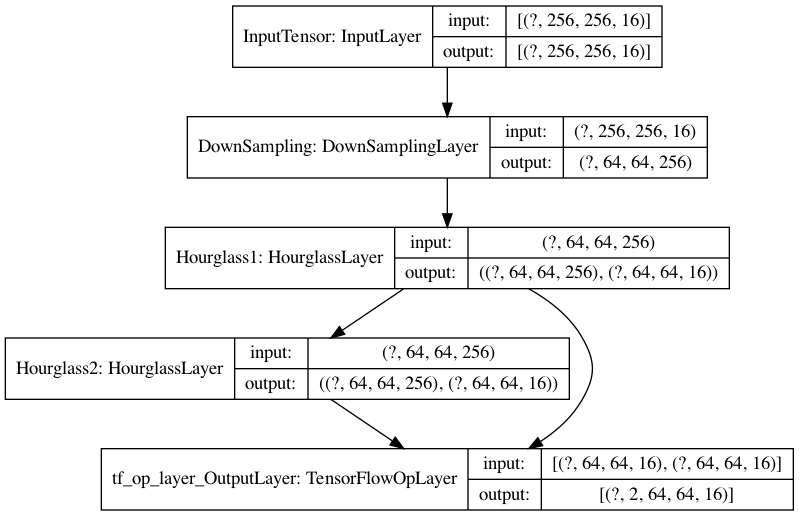

In [23]:
# Here is a simplied graph of our model with transiting shapes
tf.keras.utils.plot_model(model, show_shapes=True)

In [24]:
model.summary()

Model: "LayerByLayerHourglassNetwork"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
InputTensor (InputLayer)        [(None, 256, 256, 16 0                                            
__________________________________________________________________________________________________
DownSampling (DownSamplingLayer (None, 64, 64, 256)  340672      InputTensor[0][0]                
__________________________________________________________________________________________________
Hourglass1 (HourglassLayer)     ((None, 64, 64, 256) 2811728     DownSampling[0][0]               
__________________________________________________________________________________________________
Hourglass2 (HourglassLayer)     ((None, 64, 64, 256) 2811728     Hourglass1[0][0]                 
_______________________________________________________________________

We can now train our model, we'll use Tensorboard to track the model's evolution

In [25]:
# Create a TensorBoard callback to track the training
from datetime import datetime
logdir = f'logs/hpe_{datetime.now().strftime("%Y%m%d-%H%M%S")}'
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=logdir, histogram_freq=1)

In [26]:
# Let's generate a Fake Dataset with the adequate shapes
import numpy as np
inputs = np.random.random((20, 256, 256, 16))
outputs = np.random.random((20, 2, 64, 64, 16))
# We generate a Tensorflow Dataset
ds = tf.data.Dataset.from_tensor_slices((inputs, outputs)).take(100).batch(2)

In [27]:
# We can now fit our model
model.fit(
    ds,
    epochs=5,
    callbacks=[tensorboard_callback]
)

Epoch 1/5
 1/10 [==>...........................] - ETA: 0s - loss: 5.2801WARNING:tensorflow:From /Users/walid/.local/share/virtualenvs/hourglasstensorlfow-kuwAf2CD/lib/python3.7/site-packages/tensorflow/python/ops/summary_ops_v2.py:1277: stop (from tensorflow.python.eager.profiler) is deprecated and will be removed after 2020-07-01.
Instructions for updating:
use `tf.profiler.experimental.stop` instead.
10/10 [==============================] - 7s 722ms/step - loss: 5.0000
Epoch 2/5
10/10 [==============================] - 7s 710ms/step - loss: 4.4166
Epoch 3/5
10/10 [==============================] - 8s 803ms/step - loss: 3.7132
Epoch 4/5
10/10 [==============================] - 8s 805ms/step - loss: 3.1486
Epoch 5/5
10/10 [==============================] - 8s 754ms/step - loss: 2.7499


During the training you might see the following `WARNING` message:
```bash
WARNING:tensorflow:Gradients do not exist for variables ['Hourglass2/TransitOutput/Conv2D/kernel:0', 'Hourglass2/TransitOutput/Conv2D/bias:0', 'Hourglass2/TransitOutput/BatchNorm/gamma:0', 'Hourglass2/TransitOutput/BatchNorm/beta:0'] when minimizing the loss.
WARNING:tensorflow:Gradients do not exist for variables ['Hourglass2/TransitOutput/Conv2D/kernel:0', 'Hourglass2/TransitOutput/Conv2D/bias:0', 'Hourglass2/TransitOutput/BatchNorm/gamma:0', 'Hourglass2/TransitOutput/BatchNorm/beta:0'] when minimizing the loss.
WARNING:tensorflow:Gradients do not exist for variables ['Hourglass2/TransitOutput/Conv2D/kernel:0', 'Hourglass2/TransitOutput/Conv2D/bias:0', 'Hourglass2/TransitOutput/BatchNorm/gamma:0', 'Hourglass2/TransitOutput/BatchNorm/beta:0'] when minimizing the loss.
WARNING:tensorflow:Gradients do not exist for variables ['Hourglass2/TransitOutput/Conv2D/kernel:0', 'Hourglass2/TransitOutput/Conv2D/bias:0', 'Hourglass2/TransitOutput/BatchNorm/gamma:0', 'Hourglass2/TransitOutput/BatchNorm/beta:0'] when minimizing the loss.
```

The last transit layer is never used during the backpropagation, hence the non existing `Gradients`

### Model Approach

In [15]:
# We define our Model
model = HourglassNetwork(name="HourglassNetwork", stages=2)
# We build the Graph by specifying the input shape
model.build((None,CFG.data.input_size, CFG.data.input_size, CFG.dataset.description.n_joints))

Model: "HourglassNetwork"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
DownSampling (DownSamplingLa multiple                  340672    
_________________________________________________________________
Hourglass1 (HourglassLayer)  multiple                  2811728   
_________________________________________________________________
Hourglass2 (HourglassLayer)  multiple                  2811728   
Total params: 5,964,128
Trainable params: 5,907,360
Non-trainable params: 56,768
_________________________________________________________________


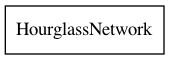

In [16]:
model.summary()
tf.keras.utils.plot_model(model, show_shapes=True)

In [17]:
# Let's generate a Fake Dataset with the adequate shapes
import numpy as np
inputs = np.random.random((20, 256, 256, 16))
outputs = np.random.random((20, 2, 64, 64, 16))
# We generate a Tensorflow Dataset
ds = tf.data.Dataset.from_tensor_slices((inputs, outputs)).take(100).batch(2)

In [18]:
# Create a TensorBoard callback to track the training
from datetime import datetime
logdir = f'logs/hpeModel_{datetime.now().strftime("%Y%m%d-%H%M%S")}'
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=logdir, histogram_freq=1)

In [19]:
# We define an optimizer and a loss function for our model
model.compile(
    optimizer=tf.keras.optimizers.RMSprop(1e-3),
    loss='binary_crossentropy',
)
# We launch the training
model.fit(
    ds,
    epochs=5,
    callbacks=[tensorboard_callback]
)

Epoch 1/5

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

 1/10 [==>...........................] - ETA: 0s - loss: 5.4415WARNING:tensorflow:From /Users/walid/.local/share/virtualenvs/hourglasstensorlfow-kuwAf2CD/lib/python3.7/site-packages/tensorflow/python/ops/summary_ops_v2.py:1277: stop (from tensorflow.python.eager.profiler) is deprecated and will be removed after 2020-07-01.
Instructions for updating:
use `tf.profiler.experimental.stop` instead.
10/10 [==============================] - 7s 743ms/step - loss: 5.0913
Epoch 2/5
10/10 [==============

### TensorBoard

**WARNING**: Using the Model Approach will prevent you from visualizing your model's graph in TensorBoard. [TensorBoard issues](https://github.com/tensorflow/tensorboard/issues)

In [29]:
# We can trace the model's evolution and other metrics with TensorBoard
import tensorboard
tensorboard.__version__
%load_ext tensorboard
%tensorboard --logdir logs

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


Reusing TensorBoard on port 6006 (pid 22280), started 0:01:41 ago. (Use '!kill 22280' to kill it.)

In [30]:
!kill 22280